## Analyzing keio plate 9

This notebook runs the analysis pipeline for the preliminary data for Keio plate 9. The cut off for lysogeny was manually set.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/home/vanvalen/Data/keio_screen/07.06.2017/keio_9/'

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [12]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [4]:
#Segment the control wells
segment_SLIP(control_direc, control_mask_direc, alphabet = row_control, columns= col_control)

['A'] [12]
Segmenting Position A12


cnn_functions.py:255: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  pooled_array +=[pool_2d(input_image[:, :, offset_x::stride, offset_y::stride], pool_size, st = (1,1), mode = mode, padding = (0,0), ignore_border = True)]
cnn_functions.py:255: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  pooled_array +=[pool_2d(input_image[:, :, offset_x::stride, offset_y::stride], pool_size, st = (1,1), mode = mode, padding = (0,0), ignore_border = True)]


Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9


In [5]:
#Segment the infected wells
segment_SLIP(data_direc, mask_direc, alphabet = row_data, columns= col_data)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Segmenting Position A1
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Segmenting Position A2
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processin

In [3]:
# Quantify the data from the control wells
mean_FITC_control, mean_cherry_control = analyze_plate(control_direc, control_mask_direc, pos_list = range(9), row_names = row_control, col_names = col_control)
mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
pickle.dump(mean_FITC_control, open(mean_FITC_control_name, 'wb'))
pickle.dump(mean_cherry_control, open(mean_cherry_control_name, 'wb'))

Processing well A12


In [4]:
# Quantify the data from the infection wells
mean_FITC, mean_cherry = analyze_plate(data_direc, mask_direc, pos_list = range(9), row_names = row_data, col_names = col_data)
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
pickle.dump(mean_FITC, open(mean_FITC_name, 'wb'))
pickle.dump(mean_cherry, open(mean_cherry_name, 'wb'))

Processing well A1
Processing well A2
Processing well A3
Processing well A4
Processing well A5
Processing well A6
Processing well A7
Processing well A8
Processing well A9
Processing well A10
Processing well A11
Processing well A12
Processing well B1
Processing well B2
Processing well B3
Processing well B4
Processing well B5
Processing well B6
Processing well B7
Processing well B8
Processing well B9
Processing well B10
Processing well B11
Processing well B12
Processing well C1
Processing well C2
Processing well C3
Processing well C4
Processing well C5
Processing well C6
Processing well C7
Processing well C8
Processing well C9
Processing well C10
Processing well C11
Processing well C12
Processing well D1
Processing well D2
Processing well D3
Processing well D4
Processing well D5
Processing well D6
Processing well D7
Processing well D8
Processing well D9
Processing well D10
Processing well D11
Processing well D12
Processing well E1
Processing well E2
Processing well E3
Processing well E4


/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Processing well H2
Processing well H3
Processing well H4
Processing well H5
Processing well H6
Processing well H7
Processing well H8
Processing well H9
Processing well H10
Processing well H11
Processing well H12


In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

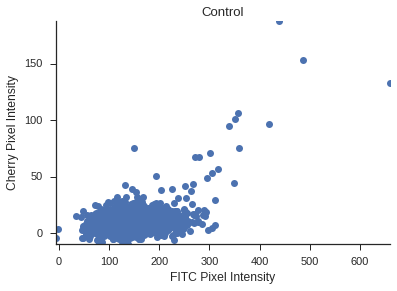

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A12', title = 'Control')
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


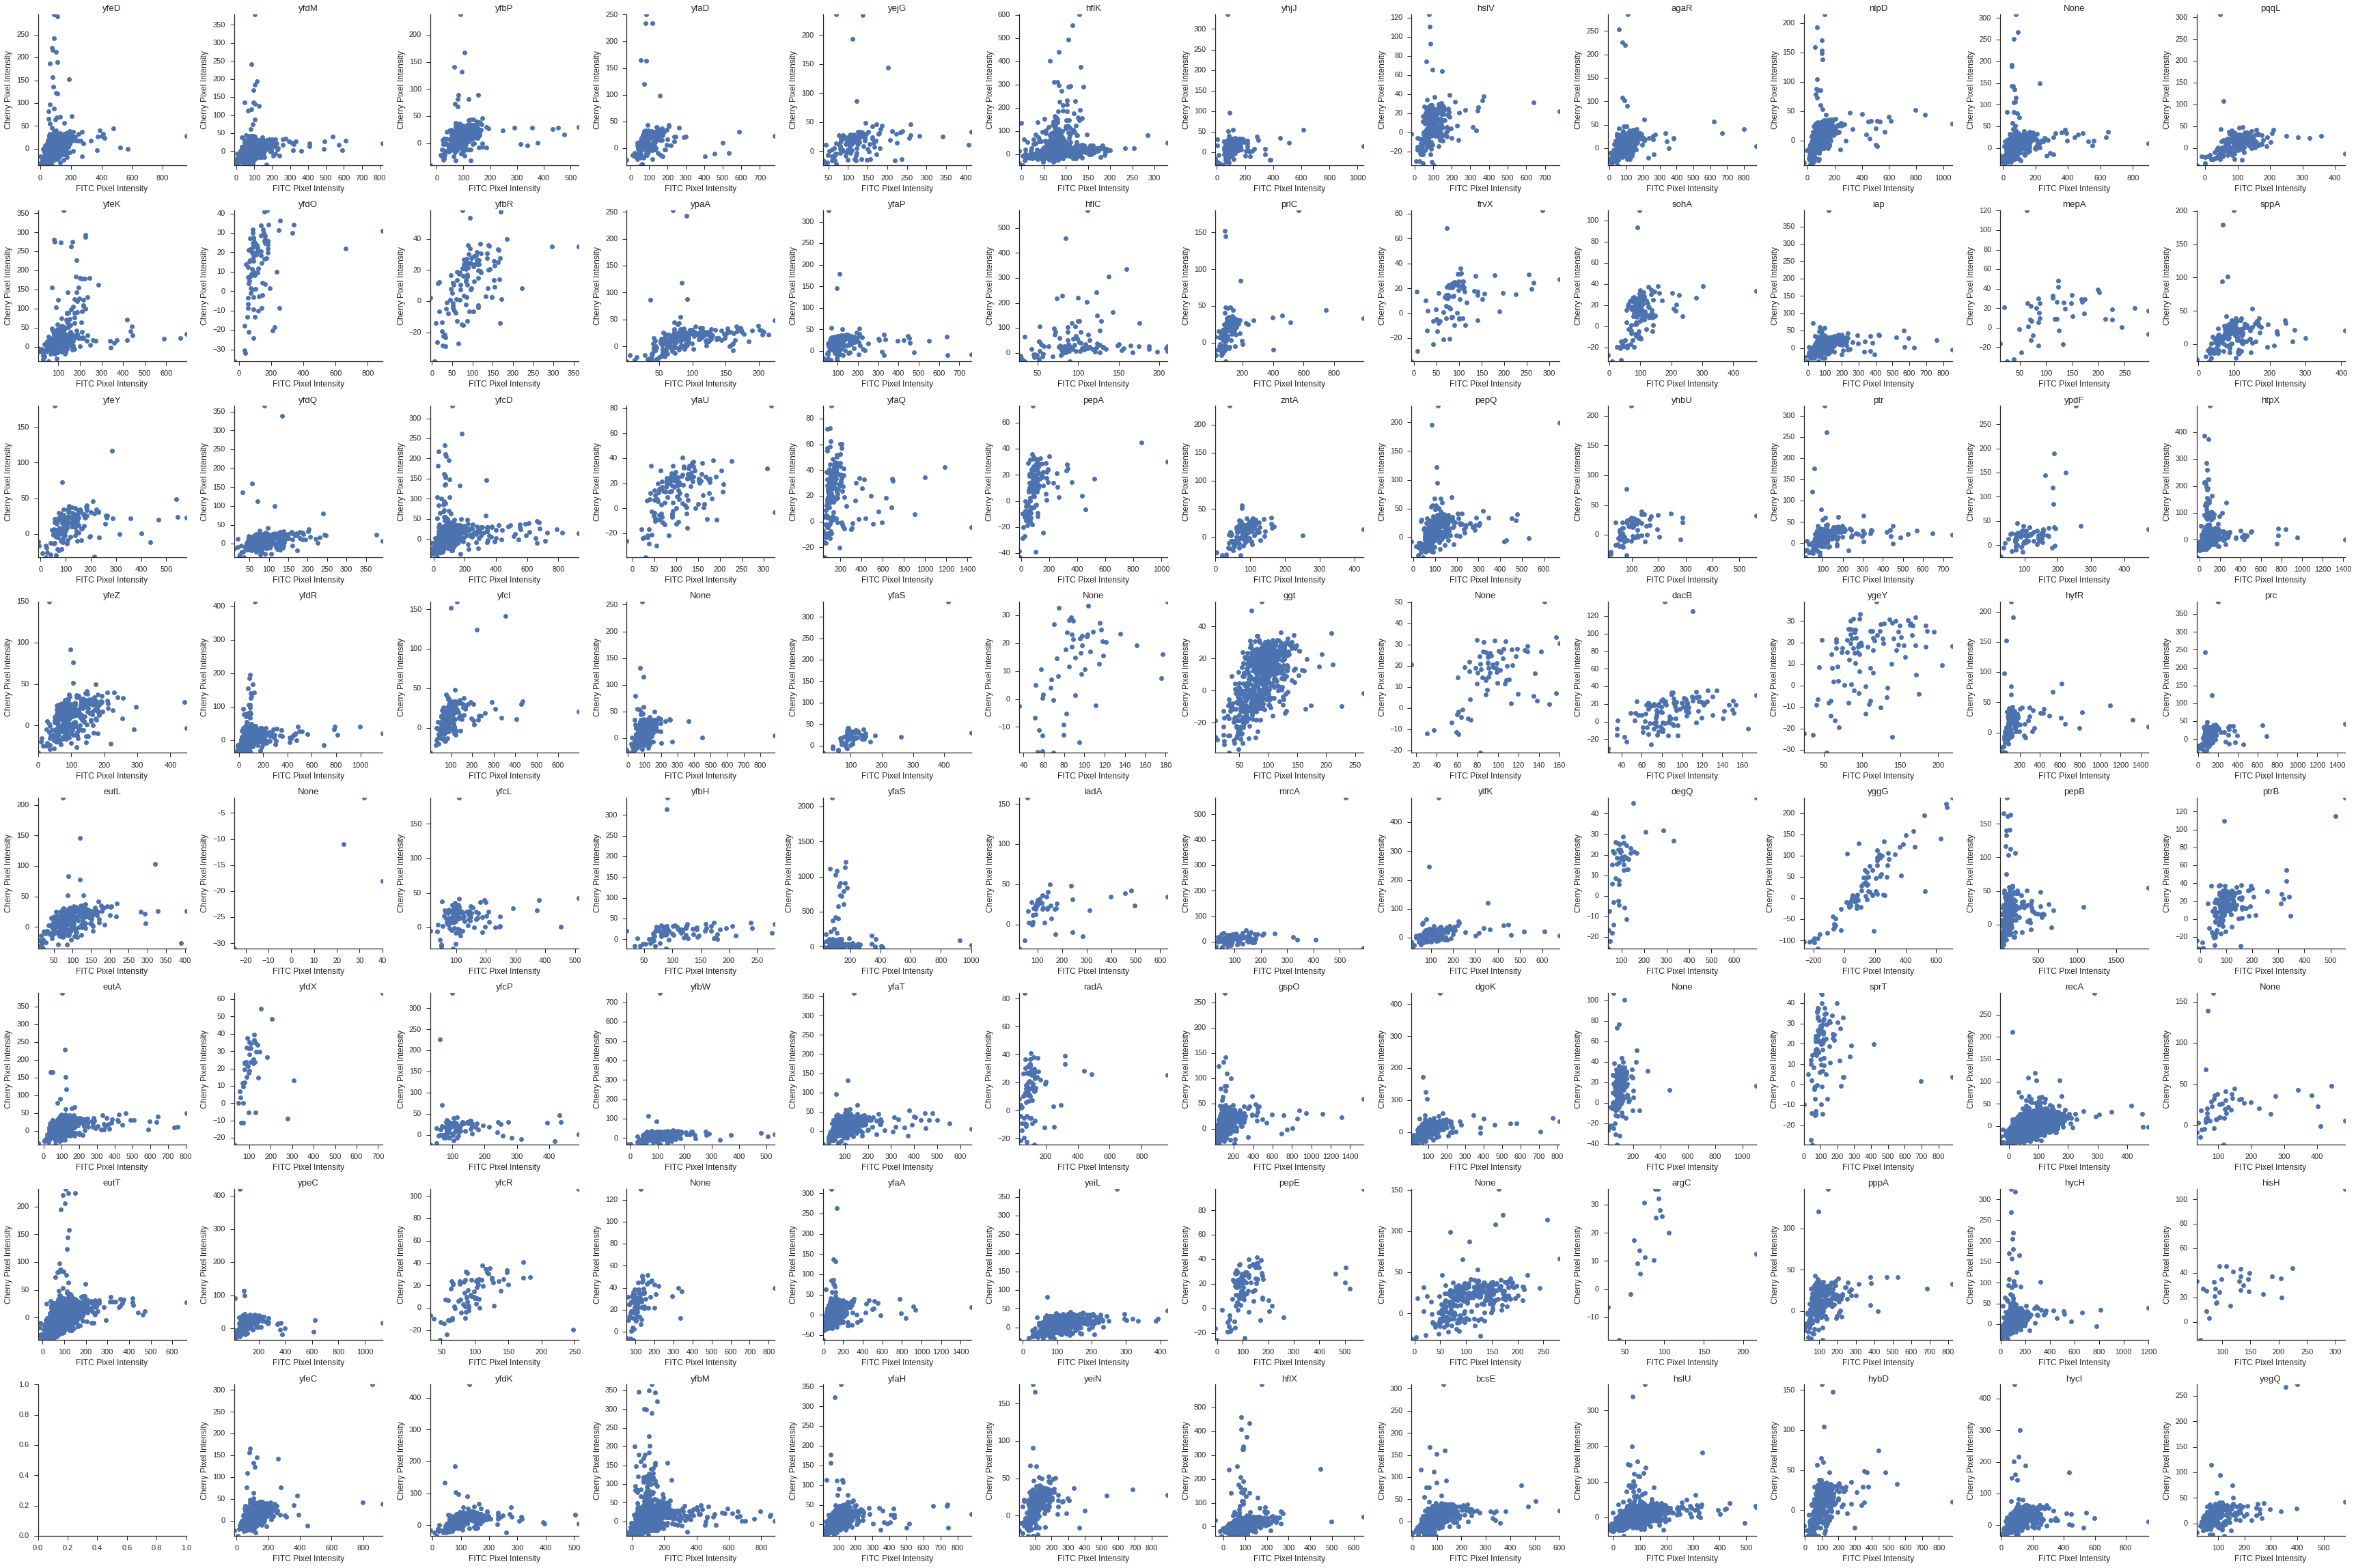

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, 9, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

In [6]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A12 1456
G7 110
G6 519
G5 1029
G4 88
G3 78
G2 216
G1 1780
G9 18
G8 278
B4 210
B5 150
B6 108
B7 118
B1 292
B2 96
B3 118
B8 84
B9 127
E9 50
E8 133
E5 144
E4 87
E7 125
E6 45
E1 278
E3 115
E2 4
H10 435
H11 726
H12 195
F12 52
F10 97
F11 2742
H8 552
H9 1445
H2 546
H3 267
H1 0
H6 329
H7 2261
H4 2374
H5 690
D10 104
D11 153
D12 192
B12 162
B10 456
B11 48
C9 76
C8 360
C3 1330
C2 256
C1 159
C7 135
C6 136
C5 176
C4 149
G12 31
G11 1045
G10 239
F1 700
F2 46
F3 86
F4 272
F5 463
F6 84
F7 642
F8 336
F9 143
E11 432
E10 90
E12 159
C12 1226
C11 72
C10 220
A11 853
A10 577
A12 188
A1 819
A3 304
A2 678
A5 129
A4 210
A7 164
A6 556
A9 501
A8 262
D8 77
D9 116
D6 56
D7 591
D4 237
D5 62
D2 1019
D3 170
D1 316


In [7]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A12')

In [8]:
# Compute the probability of observing each data point assuming there was no infection
p_values_dict = {}
for well in mean_FITC.keys():
    p_values_dict[well] = np.array(compute_p_values(mean_FITC, mean_cherry, well, kernel))

In [16]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    if np.float(p_value.shape[0]) > 0:
        fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
        fraction_infected_list += [fraction_infected]
    
        print well, fraction_infected, np.float(np.where(p_value < 0.01)[0].shape[0])

G7 0.0454545454545 5.0
G6 0.019267822736 10.0
G5 0.0340136054422 35.0
G4 0.0909090909091 8.0
G3 0.0128205128205 1.0
G2 0.0601851851852 13.0
G1 0.0207865168539 37.0
G9 0.0 0.0
G8 0.0359712230216 10.0
B4 0.0333333333333 7.0
B5 0.14 21.0
B6 0.296296296296 32.0
B7 0.0847457627119 10.0
B1 0.219178082192 64.0
B2 0.0416666666667 4.0
B3 0.0423728813559 5.0
B8 0.0357142857143 3.0
B9 0.0314960629921 4.0
E9 0.06 3.0
E8 0.12030075188 16.0
E5 0.409722222222 59.0
E4 0.0344827586207 3.0
E7 0.04 5.0
E6 0.2 9.0
E1 0.0395683453237 11.0
E3 0.0521739130435 6.0
E2 0.0 0.0
H10 0.0413793103448 18.0
H11 0.0853994490358 62.0
H12 0.0615384615385 12.0
F12 0.173076923077 9.0
F10 0.0309278350515 3.0
F11 0.010576221736 29.0
H8 0.0416666666667 23.0
H9 0.0352941176471 51.0
H2 0.03663003663 20.0
H3 0.0711610486891 19.0
H6 0.0516717325228 17.0
H7 0.0181335692172 41.0
H4 0.0606571187869 144.0
H5 0.0507246376812 35.0
D10 0.0 0.0
D11 0.156862745098 24.0
D12 0.0833333333333 16.0
B12 0.0432098765432 7.0
B10 0.0438596491228 

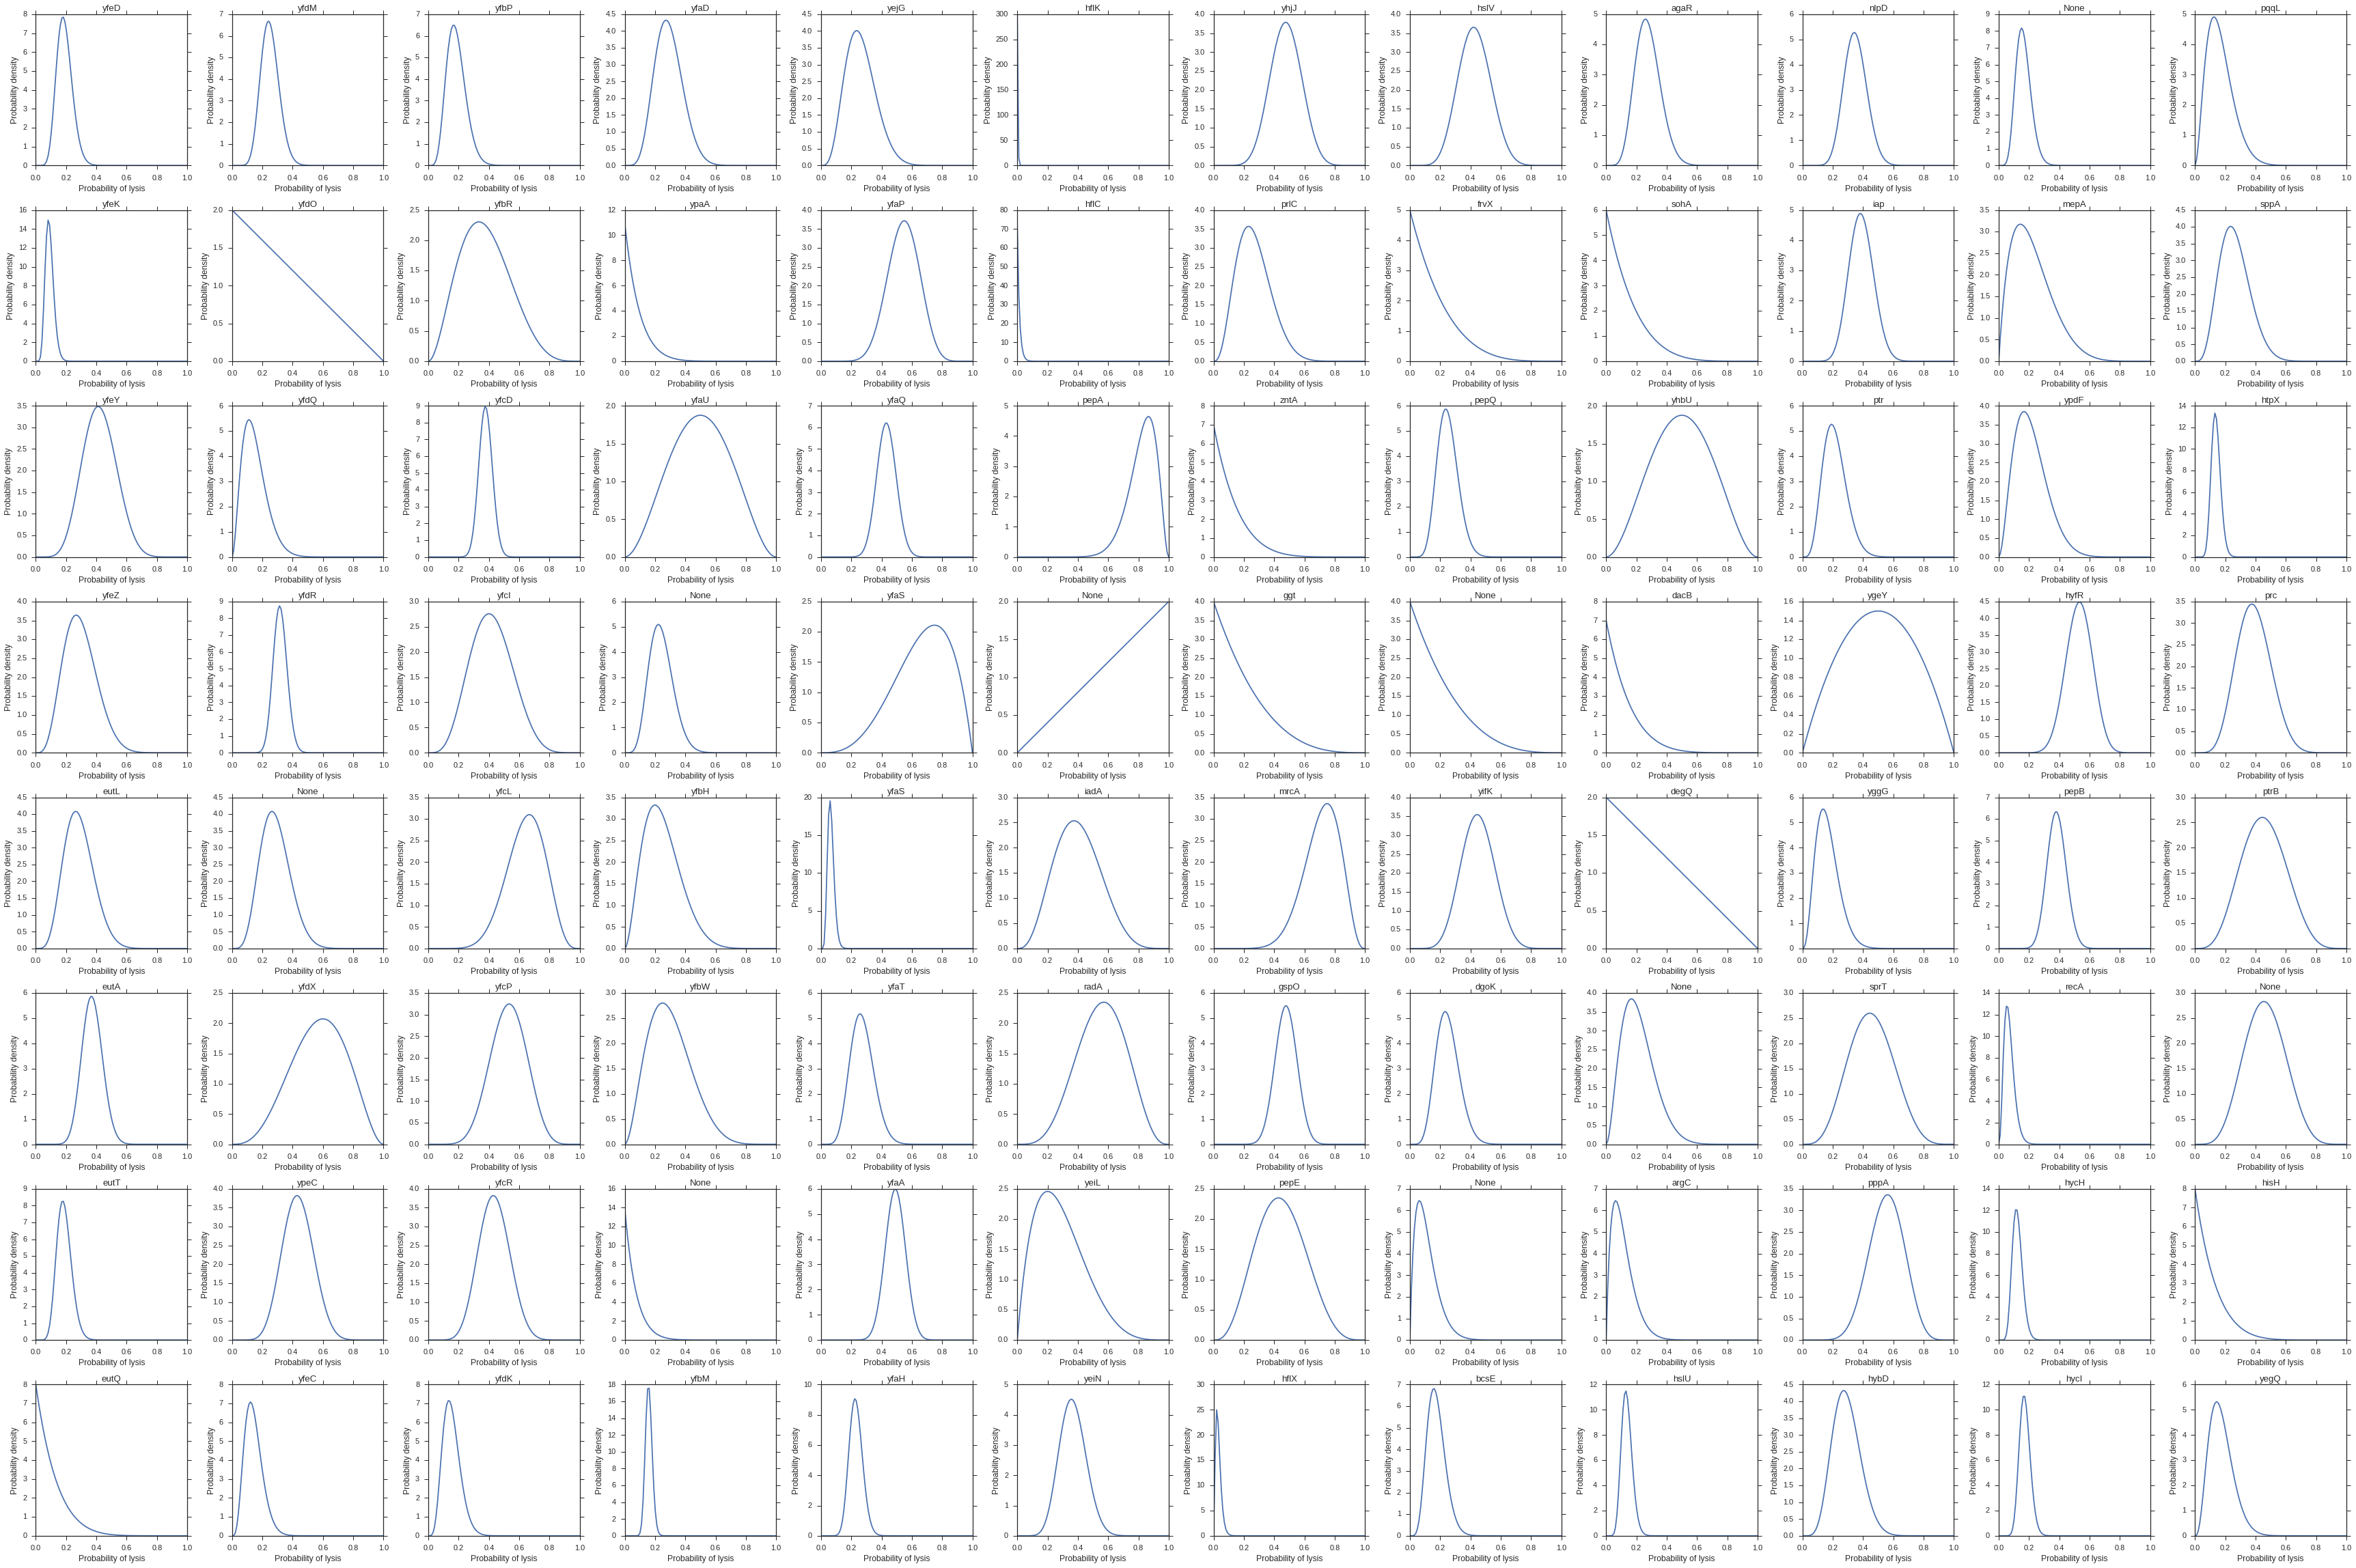

In [15]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A12'])
cherry_control_array = np.array(mean_cherry_control['A12'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = 9, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

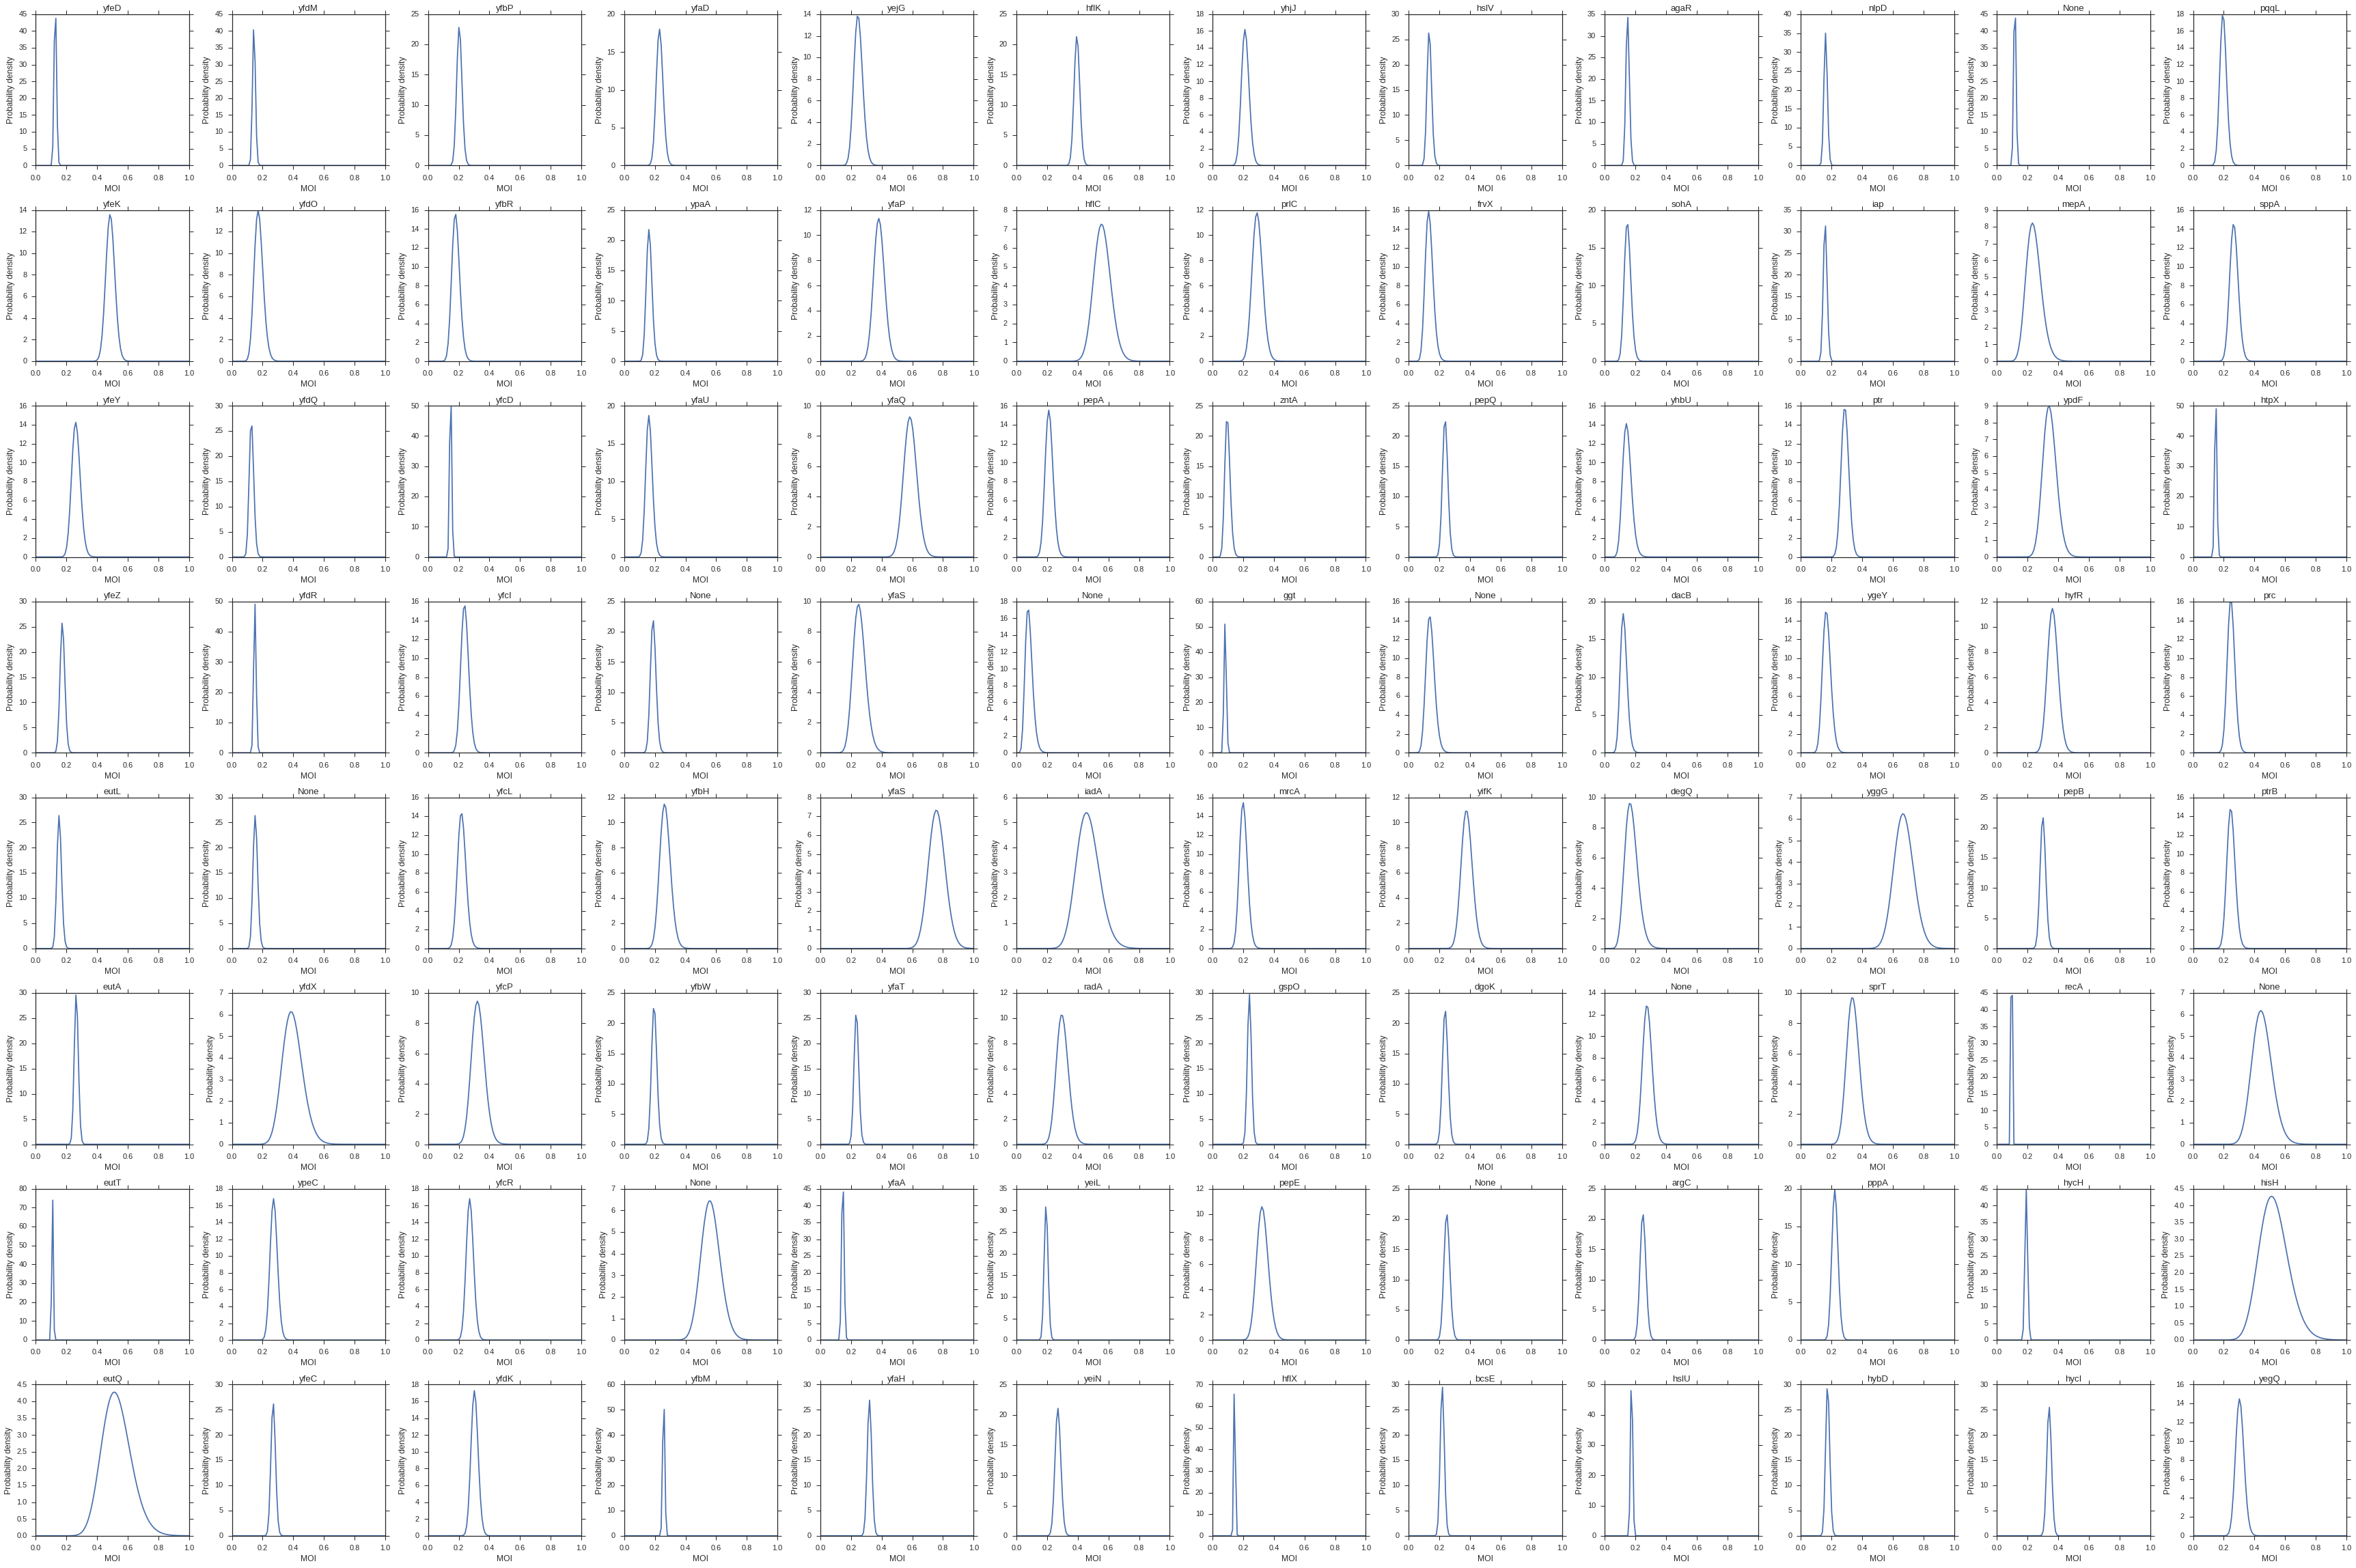

In [25]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,2,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = 9, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()